# dependencies

In [387]:
# general
import os, sys

# data manipulation
import json
import pandas as pd
import numpy as np

# pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# validate
from sklearn.model_selection import cross_validate, cross_val_score

# hyperparameter optimization
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# visualization
from matplotlib import pyplot as plt
from skopt.plots import plot_convergence

%matplotlib inline

In [382]:
def skot_hyperopt(space, model, x, y):
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)

        return -np.mean(cross_val_score(model, x, y, cv=5, n_jobs=-1,
                                        scoring="accuracy"))
    res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
    return res_gp

# set-up

In [15]:
CURRENTPATH = os.getcwd()
DATAPATH = os.path.join(CURRENTPATH, 'dat')
INPATH = os.path.join(DATAPATH, 'in')
RAWDATAPATH = os.path.join(INPATH, 'attempts.json')

In [18]:
?pd.read_json

In [35]:
with open(RAWDATAPATH) as f:
    string = f.readlines()

In [43]:
newstr = []
for i in string:
    tmpstr = i.strip('\n')
    newstr.append(json.loads(tmpstr))


In [44]:
data = pd.DataFrame.from_records(newstr)

In [347]:
def date_enrichment(df, colName):
    # day
    df['Day'] = df[colName].dt.day
    # month
    df['Month'] = df[colName].dt.month
    # year
    df['Year'] = df[colName].dt.year
    # hour
    df['Start_hour'] = df[colName].dt.hour
    # minute
    df['Start_minute'] = df[colName].dt.minute
    # second
    df['Start_second'] = df[colName].dt.second
    # Monday is 0 and Sunday is 6
    df['Start_weekday'] = df[colName].dt.weekday
    # week of the year
    df['Start_week_of_year'] = df[colName].dt.week
    df = df.drop(colName, axis=1)
    return df

# eda

In [45]:
data.head()

,answer,answer_is_correct,attempt_id,attempt_number,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,...,only_preloaded,position,quiz_id,quiz_user_try_number,session_key,solvable_id,started,topic_id,user_id,viewed_solution
0,Numerical data representing images of dogs and...,True,246437787,1,False,False,False,False,quizzes,quizproblemset,...,False,2.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113115,2017-12-24T19:58:28.409597,15,5202480,False
1,Split the images randomly into two sets: one f...,True,246437788,1,False,False,False,False,quizzes,quizproblemset,...,False,3.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113116,2017-12-24T20:00:47.137714,15,5202480,False
2,The green model (dashes),True,246437789,1,False,False,False,False,quizzes,quizproblemset,...,False,5.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113117,2017-12-24T20:01:53.487885,15,5202480,False
3,1,False,246437790,1,False,False,False,False,quizzes,quizproblemset,...,False,7.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113118,2017-12-24T20:02:48.636948,15,5202480,True
4,Predicting someone’s gender from their name,True,246437791,1,False,False,False,False,quizzes,quizproblemset,...,False,8.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113119,2017-12-24T20:04:46.078238,15,5202480,False


In [93]:
data.dtypes

answer                   object
answer_is_correct          bool
attempt_id                int64
attempt_number            int64
challenge_quiz             bool
community_attempt          bool
concept_quiz               bool
daily_problem_quiz         bool
django_app               object
django_model             object
exploration_quiz           bool
flags                     int64
object_id               float64
old_practice_attempt       bool
only_preloaded             bool
position                float64
quiz_id                 float64
quiz_user_try_number    float64
session_key              object
solvable_id               int64
started                  object
topic_id                  int64
user_id                   int64
viewed_solution            bool
dtype: object

In [47]:
data.columns

Index(['answer', 'answer_is_correct', 'attempt_id', 'attempt_number',
       'challenge_quiz', 'community_attempt', 'concept_quiz',
       'daily_problem_quiz', 'django_app', 'django_model', 'exploration_quiz',
       'flags', 'object_id', 'old_practice_attempt', 'only_preloaded',
       'position', 'quiz_id', 'quiz_user_try_number', 'session_key',
       'solvable_id', 'started', 'topic_id', 'user_id', 'viewed_solution'],
      dtype='object')

In [70]:
data.daily_problem_quiz.value_counts()

False    3426
True      270
Name: daily_problem_quiz, dtype: int64

In [81]:
data.describe

In [92]:
data.describe(include=["object", "bool"])

,answer,answer_is_correct,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,exploration_quiz,old_practice_attempt,only_preloaded,session_key,started,viewed_solution
count,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696
unique,1863,2,2,2,2,2,2,2,2,1,2,62,3696,2
top,,True,False,False,False,False,quizzes,quizproblemset,True,False,False,83j00rdz4mg5fbba5mv89si1kt2cxlq5,2018-04-25T21:11:29.336455,False
freq,672,2600,3691,3676,3636,3426,3406,3406,3131,3696,3235,760,1,3440


In [86]:
data.describe(exclude=['int', 'float'])

,answer,answer_is_correct,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,exploration_quiz,old_practice_attempt,only_preloaded,session_key,started,viewed_solution
count,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696,3696
unique,1863,2,2,2,2,2,2,2,2,1,2,62,3696,2
top,,True,False,False,False,False,quizzes,quizproblemset,True,False,False,83j00rdz4mg5fbba5mv89si1kt2cxlq5,2018-04-25T21:11:29.336455,False
freq,672,2600,3691,3676,3636,3426,3406,3406,3131,3696,3235,760,1,3440


In [67]:
data.describe()

,attempt_id,attempt_number,flags,object_id,position,quiz_id,quiz_user_try_number,solvable_id,topic_id,user_id
count,3.696000e+03,3696.000000,3696.000000,3406.000000,3406.000000,3406.000000,3406.000000,3696.000000,3696.000000,3696.0
mean,3.737833e+08,0.819535,12.417749,51226.075455,5.258955,5993.635643,1.270699,135230.992695,20.935877,5202480.0
std,8.491806e+07,0.386031,33.436738,20892.499234,2.895924,1229.849326,0.617992,21529.951260,21.798771,0.0
min,2.464378e+08,0.000000,0.000000,65.000000,1.000000,1541.000000,1.000000,690.000000,5.000000,5202480.0
25%,2.961306e+08,1.000000,0.000000,40456.000000,3.000000,5150.000000,1.000000,120172.500000,14.000000,5202480.0
50%,3.786215e+08,1.000000,0.000000,47928.500000,5.000000,5857.000000,1.000000,132875.000000,15.000000,5202480.0
75%,4.495368e+08,1.000000,8.000000,57983.500000,7.000000,6423.000000,1.000000,148482.000000,18.000000,5202480.0
max,4.990481e+08,2.000000,128.000000,130471.000000,16.000000,8925.000000,6.000000,177886.000000,162.000000,5202480.0


In [59]:
total = data[data.attempt_number>0].shape[0]

In [60]:
correct = data.answer_is_correct.sum()

In [61]:
correct/total

0.8589362405021473

In [62]:
print(correct, total)

2600 3027


In [65]:
data.groupby("attempt_number").size()

attempt_number
0     669
1    3025
2       2
dtype: int64

# pre-processing

In [301]:
data.head()


,answer,answer_is_correct,attempt_id,attempt_number,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,...,only_preloaded,position,quiz_id,quiz_user_try_number,session_key,solvable_id,started,topic_id,user_id,viewed_solution
0,Numerical data representing images of dogs and...,True,246437787,1,False,False,False,False,quizzes,quizproblemset,...,False,2.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113115,2017-12-24T19:58:28.409597,15,5202480,False
1,Split the images randomly into two sets: one f...,True,246437788,1,False,False,False,False,quizzes,quizproblemset,...,False,3.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113116,2017-12-24T20:00:47.137714,15,5202480,False
2,The green model (dashes),True,246437789,1,False,False,False,False,quizzes,quizproblemset,...,False,5.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113117,2017-12-24T20:01:53.487885,15,5202480,False
3,1,False,246437790,1,False,False,False,False,quizzes,quizproblemset,...,False,7.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113118,2017-12-24T20:02:48.636948,15,5202480,True
4,Predicting someone’s gender from their name,True,246437791,1,False,False,False,False,quizzes,quizproblemset,...,False,8.0,4786.0,1.0,tjywtkhwv4du6wccypfdk9kg44upk9i9,113119,2017-12-24T20:04:46.078238,15,5202480,False


In [316]:
df = data[data["attempt_number"]!=0]

In [317]:
df = df.reset_index()

In [318]:
data.shape, df.shape

((3696, 24), (3027, 25))

In [319]:
df = df.drop(["index", "old_practice_attempt", "only_preloaded","object_id", "attempt_id", "answer","quiz_id", "session_key", "topic_id", "user_id", "viewed_solution", "solvable_id"], axis=1)

In [320]:
df.head()

,answer_is_correct,attempt_number,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,exploration_quiz,flags,position,quiz_user_try_number,started
0,True,1,False,False,False,False,quizzes,quizproblemset,True,0,2.0,1.0,2017-12-24T19:58:28.409597
1,True,1,False,False,False,False,quizzes,quizproblemset,True,0,3.0,1.0,2017-12-24T20:00:47.137714
2,True,1,False,False,False,False,quizzes,quizproblemset,True,0,5.0,1.0,2017-12-24T20:01:53.487885
3,False,1,False,False,False,False,quizzes,quizproblemset,True,0,7.0,1.0,2017-12-24T20:02:48.636948
4,True,1,False,False,False,False,quizzes,quizproblemset,True,0,8.0,1.0,2017-12-24T20:04:46.078238


In [321]:
df.describe(include="all")

,answer_is_correct,attempt_number,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,django_app,django_model,exploration_quiz,flags,position,quiz_user_try_number,started
count,3027,3027.000000,3027,3027,3027,3027,3027,3027,3027,3027.000000,2804.000000,2804.000000,3027
unique,2,NaN,1,2,2,2,2,2,2,NaN,NaN,NaN,3027
top,True,NaN,False,False,False,False,quizzes,quizproblemset,True,NaN,NaN,NaN,2018-09-30T07:56:06.001485
freq,2600,NaN,3027,3018,3000,2813,2804,2804,2712,NaN,NaN,NaN,1
mean,NaN,1.000661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.480674,5.204351,1.291726,NaN
std,NaN,0.025700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.236518,2.841132,0.645898,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN
25%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,3.000000,1.000000,NaN
50%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.000000,1.000000,NaN
75%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.000000,1.000000,NaN


In [322]:
df.dtypes

answer_is_correct          bool
attempt_number            int64
challenge_quiz             bool
community_attempt          bool
concept_quiz               bool
daily_problem_quiz         bool
django_app               object
django_model             object
exploration_quiz           bool
flags                     int64
position                float64
quiz_user_try_number    float64
started                  object
dtype: object

In [323]:
# all columns
g = dict(df.columns.to_series().groupby(df.dtypes).groups)
cols = {k.name: list(v) for k, v in g.items()}
cols

{'bool': ['answer_is_correct',
  'challenge_quiz',
  'community_attempt',
  'concept_quiz',
  'daily_problem_quiz',
  'exploration_quiz'],
 'int64': ['attempt_number', 'flags'],
 'float64': ['position', 'quiz_user_try_number'],
 'object': ['django_app', 'django_model', 'started']}

In [324]:
# boolean variables
bool_cols = cols["bool"]
bool_cols

['answer_is_correct',
 'challenge_quiz',
 'community_attempt',
 'concept_quiz',
 'daily_problem_quiz',
 'exploration_quiz']

In [325]:
bools = pd.DataFrame()
for col in bool_cols:
    bools[col] = df[col]*1

In [326]:
# numerical variables
num_cols = cols["int64"]+cols["float64"]
num_cols

['attempt_number', 'flags', 'position', 'quiz_user_try_number']

In [327]:
nums_imputed = pd.DataFrame(SimpleImputer().fit_transform(df[num_cols]), columns=num_cols)
nums_imputed

,attempt_number,flags,position,quiz_user_try_number
0,1.0,0.0,2.000000,1.000000
1,1.0,0.0,3.000000,1.000000
2,1.0,0.0,5.000000,1.000000
3,1.0,0.0,7.000000,1.000000
4,1.0,0.0,8.000000,1.000000
...,...,...,...,...
3022,1.0,0.0,9.000000,1.000000
3023,1.0,0.0,11.000000,1.000000
3024,1.0,0.0,12.000000,1.000000
3025,1.0,128.0,5.204351,1.291726


In [328]:
rst = RobustScaler().fit(nums_imputed)
nums_scaled = pd.DataFrame(rst.transform(nums_imputed), columns = num_cols)
nums_scaled

,attempt_number,flags,position,quiz_user_try_number
0,0.0,0.0,-0.750000,0.0
1,0.0,0.0,-0.500000,0.0
2,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.500000,0.0
4,0.0,0.0,0.750000,0.0
...,...,...,...,...
3022,0.0,0.0,1.000000,0.0
3023,0.0,0.0,1.500000,0.0
3024,0.0,0.0,1.750000,0.0
3025,0.0,128.0,0.051088,1.0


In [329]:
# categorical variables
cat_cols = cols["object"]
cat_cols.remove('started')
cat_cols

['django_app', 'django_model']

In [330]:
cats = df[cat_cols]
cats

,django_app,django_model
0,quizzes,quizproblemset
1,quizzes,quizproblemset
2,quizzes,quizproblemset
3,quizzes,quizproblemset
4,quizzes,quizproblemset
...,...,...
3022,quizzes,quizproblemset
3023,quizzes,quizproblemset
3024,quizzes,quizproblemset
3025,,


In [331]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cats = pd.DataFrame(ohe.fit_transform(cats))
print(ohe.get_feature_names())
cats.columns = ohe.get_feature_names()

['x0_' 'x0_quizzes' 'x1_' 'x1_quizproblemset']


In [348]:
# temporal data
t_cols = ['started']
temps = df[t_cols]
temps

,started
0,2017-12-24T19:58:28.409597
1,2017-12-24T20:00:47.137714
2,2017-12-24T20:01:53.487885
3,2017-12-24T20:02:48.636948
4,2017-12-24T20:04:46.078238
...,...
3022,2020-12-22T09:55:43.574787
3023,2020-12-22T09:57:53.241227
3024,2020-12-22T10:46:12.655894
3025,2020-12-22T11:39:56.366776


In [349]:
temps = pd.to_datetime(temps['started'], format="%Y-%m-%dT%H:%M:%S")
temps = pd.DataFrame(temps)

In [350]:
enriched = date_enrichment(temps, 'started')


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [351]:
enriched

,Day,Month,Year,Start_hour,Start_minute,Start_second,Start_weekday,Start_week_of_year
0,24,12,2017,19,58,28,6,51
1,24,12,2017,20,0,47,6,51
2,24,12,2017,20,1,53,6,51
3,24,12,2017,20,2,48,6,51
4,24,12,2017,20,4,46,6,51
...,...,...,...,...,...,...,...,...
3022,22,12,2020,9,55,43,1,52
3023,22,12,2020,9,57,53,1,52
3024,22,12,2020,10,46,12,1,52
3025,22,12,2020,11,39,56,1,52


In [352]:
bools.shape, nums_scaled.shape, cats.shape, enriched.shape

((3027, 6), (3027, 4), (3027, 4), (3027, 8))

In [353]:
# merge data
df_pp = pd.concat([bools, nums_scaled, cats, enriched],axis=1)

In [354]:
df_pp

,answer_is_correct,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,exploration_quiz,attempt_number,flags,position,quiz_user_try_number,...,x1_,x1_quizproblemset,Day,Month,Year,Start_hour,Start_minute,Start_second,Start_weekday,Start_week_of_year
0,1,0,0,0,0,1,0.0,0.0,-0.750000,0.0,...,0.0,1.0,24,12,2017,19,58,28,6,51
1,1,0,0,0,0,1,0.0,0.0,-0.500000,0.0,...,0.0,1.0,24,12,2017,20,0,47,6,51
2,1,0,0,0,0,1,0.0,0.0,0.000000,0.0,...,0.0,1.0,24,12,2017,20,1,53,6,51
3,0,0,0,0,0,1,0.0,0.0,0.500000,0.0,...,0.0,1.0,24,12,2017,20,2,48,6,51
4,1,0,0,0,0,1,0.0,0.0,0.750000,0.0,...,0.0,1.0,24,12,2017,20,4,46,6,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,1,0,0,0,0,1,0.0,0.0,1.000000,0.0,...,0.0,1.0,22,12,2020,9,55,43,1,52
3023,1,0,0,0,0,1,0.0,0.0,1.500000,0.0,...,0.0,1.0,22,12,2020,9,57,53,1,52
3024,1,0,0,0,0,1,0.0,0.0,1.750000,0.0,...,0.0,1.0,22,12,2020,10,46,12,1,52
3025,1,0,0,0,1,0,0.0,128.0,0.051088,1.0,...,1.0,0.0,22,12,2020,11,39,56,1,52


In [355]:
df_pp.dtypes

answer_is_correct         int64
challenge_quiz            int64
community_attempt         int64
concept_quiz              int64
daily_problem_quiz        int64
exploration_quiz          int64
attempt_number          float64
flags                   float64
position                float64
quiz_user_try_number    float64
x0_                     float64
x0_quizzes              float64
x1_                     float64
x1_quizproblemset       float64
Day                       int64
Month                     int64
Year                      int64
Start_hour                int64
Start_minute              int64
Start_second              int64
Start_weekday             int64
Start_week_of_year        int64
dtype: object

In [360]:
y = df_pp["answer_is_correct"]
x = df_pp.drop("answer_is_correct", axis=1)

In [418]:
x.describe()

,challenge_quiz,community_attempt,concept_quiz,daily_problem_quiz,exploration_quiz,attempt_number,flags,position,quiz_user_try_number,x0_,...,x1_,x1_quizproblemset,Day,Month,Year,Start_hour,Start_minute,Start_second,Start_weekday,Start_week_of_year
count,3027.0,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,...,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000,3027.000000
mean,0.0,0.002973,0.008920,0.070697,0.895937,0.000661,11.480674,0.051088,1.000000,0.073670,...,0.073670,0.926330,17.480344,7.294020,2018.882061,13.185993,29.608854,29.613479,2.966303,29.982161
std,0.0,0.054455,0.094038,0.256360,0.305393,0.025700,33.236518,0.683610,2.130914,0.261277,...,0.261277,0.261277,8.085498,3.736545,0.887025,5.840926,18.014800,17.197405,2.113483,16.577334
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,...,0.000000,1.000000,12.000000,4.000000,2018.000000,8.000000,13.000000,15.000000,1.000000,15.000000
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,18.000000,8.000000,2019.000000,13.000000,30.000000,29.000000,3.000000,31.000000
75%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,1.000000,0.000000,...,0.000000,1.000000,24.000000,11.000000,2020.000000,18.000000,46.000000,45.000000,5.000000,46.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,128.000000,2.500000,17.139364,1.000000,...,1.000000,1.000000,31.000000,12.000000,2020.000000,23.000000,59.000000,59.000000,6.000000,52.000000


# modeling

In [361]:
lr = LogisticRegression()
scoring = ('accuracy', 'r2')
cvScr = cross_validate(lr,x,y,cv=5, 
                       scoring=scoring, 
                       return_train_score=True)

/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/alex/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

In [362]:
cvScr['test_accuracy'].mean()

0.8562921746720127

In [372]:
rfc = RandomForestClassifier()
rfcCV = cross_validate(rfc,x,y,cv=5, 
                       scoring=scoring, 
                       return_train_score=True)

In [373]:
rfcCV

{'fit_time': array([0.30563426, 0.29508257, 0.28788114, 0.29037833, 0.28851581]),
 'score_time': array([0.01806855, 0.0186801 , 0.01933599, 0.01978779, 0.01915646]),
 'test_accuracy': array([0.7689769 , 0.68151815, 0.66280992, 0.61157025, 0.85950413]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_r2': array([-0.89713775, -1.61533989, -1.79230769, -2.21662896, -0.16346154]),
 'train_r2': array([1., 1., 1., 1., 1.])}

In [374]:
rfcCV['test_accuracy'].mean()

0.7168758694051223

# tuning

In [388]:
space  = [  Integer(10, 100, name='n_estimators'),
            Integer(10, 100, name='max_depth'),
            Integer(1, 100, name='min_samples_leaf'),
            Integer(2, 50, name='min_samples_split') #,
            #Categorical(['auto', 'sqrt', 'log2'], name='max_features')
         ]

res_gp_rf = skot_hyperopt(space, rfc, x, y)

Best score=-0.8821
Best parameters:
n_estimators=82
max_depth=26
min_samples_leaf=10
min_samples_split=22



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

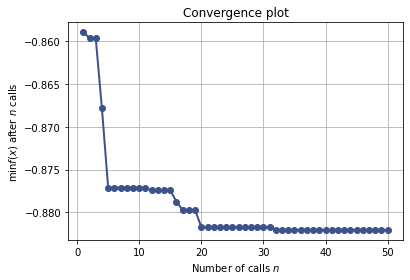

In [389]:
print("Best score=%.4f" % res_gp_rf.fun)
print("""Best parameters:
n_estimators=%d
max_depth=%d
min_samples_leaf=%d
min_samples_split=%d
""" % (res_gp_rf.x[0], res_gp_rf.x[1],res_gp_rf.x[2], res_gp_rf.x[3]))
plot_convergence(res_gp_rf)

In [390]:
rfc = RandomForestClassifier(
                           oob_score=True,
                           n_estimators=82,
                           max_depth=26,
                           min_samples_leaf=10,
                           min_samples_split=22)

rfcCV = cross_validate(rfc,x,y,cv=5, 
                       scoring=scoring, 
                       return_train_score=True)



In [398]:
rfc.fit(x,y)

RandomForestClassifier(max_depth=26, min_samples_leaf=10, min_samples_split=22,
                       n_estimators=82, oob_score=True)

In [392]:
rfcCV['test_accuracy'].mean()

0.882380056187437

In [397]:
??rfc

<AxesSubplot:>

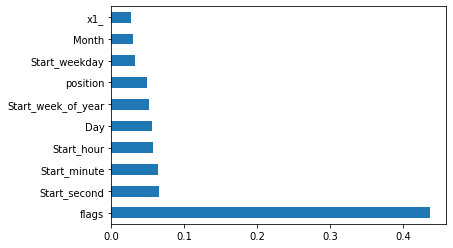

In [416]:
(pd.Series(rfc.feature_importances_, index=x.columns)
   .nlargest(10)
   .plot(kind='barh')) 

In [444]:
labels = []
for i in indices:
    labels.append(x.columns[i])

In [421]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

In [441]:
range(x.shape[1])

range(0, 21)

In [439]:
indices

array([ 0,  1,  5,  2,  4, 12,  9,  8,  3, 10, 15, 11, 14, 19,  7, 20, 13,
       16, 17, 18,  6])

In [443]:
labels

'flags'

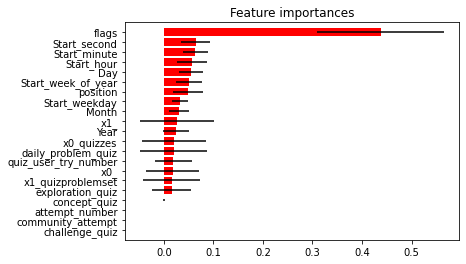

In [446]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(x.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
#plt.yticks(range(x.shape[1]), indices)
plt.yticks(range(x.shape[1]),labels)
plt.ylim([-1, x.shape[1]])
plt.show()

In [452]:
pd.DataFrame(x["flags"]).groupby("flags").size()

flags
0.0      2583
32.0      230
128.0     214
dtype: int64

In [454]:
pd.DataFrame(data["flags"]).groupby("flags").size()

flags
0      2728
8       460
32      237
72        1
128     270
dtype: int64

In [458]:
data.groupby(["attempt_number", "flags"]).size()

attempt_number  flags
0               0         145
                8         460
                32          7
                72          1
                128        56
1               0        2581
                32        230
                128       214
2               0           2
dtype: int64

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
3022      0.0
3023      0.0
3024      0.0
3025    128.0
3026    128.0
Name: flags, Length: 3027, dtype: float64

In [487]:
finalDF = pd.DataFrame({"flags":list(x.flags), "correct":list(y)})
finalDF.groupby('flags').correct.sum()/finalDF.shape[0]

flags
0.0      0.777337
32.0     0.019822
128.0    0.061777
Name: correct, dtype: float64

In [462]:
idx = x[x.flags>0].index

In [475]:
flags = list(x.flags[idx])
correct = list(y[idx])
final = pd.DataFrame({"flags":flags, "correct": correct})

In [479]:
final.shape

(444, 2)

In [480]:
final.groupby("flags").correct.agg(sum)/444

flags
32.0     0.135135
128.0    0.421171
Name: correct, dtype: float64